In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.image as mpimg
import torch
from torch.utils.data import Dataset
from skimage.color import gray2rgb
import cv2
from torchvision import transforms, utils
from skimage import io, transform
from torch.utils.data import DataLoader
import torchvision.models as models
import time
from torch.autograd import Variable

%matplotlib inline

In [2]:
!pwd

/home/yangliu/project/xray


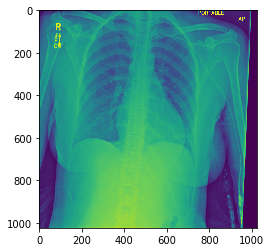

In [3]:
img=mpimg.imread('../../../../media/data/yangliu/xrays/images/00023128_013.png')
imgplot = plt.imshow(img)
plt.show()

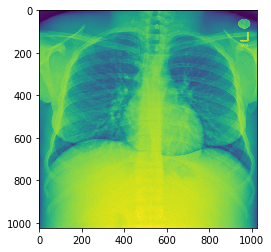

In [4]:
img2=mpimg.imread('../../../../media/data/yangliu/xrays/images/00005344_000.png')
imgplot = plt.imshow(img2)
plt.show()

In [5]:
img.shape, img2.shape

((1024, 1024), (1024, 1024))

In [6]:
img

array([[ 0.        ,  0.00784314,  0.02352941, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.01568628,  0.03921569, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.01176471,  0.03921569, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.02745098,  0.09411765, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.02352941,  0.07843138, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

1.resize&color normalization 2.detection(bounding box)

In [7]:
class data_loader(Dataset):
    def __init__(self, label_dict, image_dir, transform=None):
        self.label_dt = pd.read_csv(label_dict)
        self.image_dir = image_dir
        self.transform = transform
        
    def __getitem__(self, idx, split=None):
        img_name = os.path.join(self.image_dir, self.label_dt.keys()[idx])
        image = mpimg.imread(img_name)
        labels = np.array(self.label_dt[self.label_dt.keys()[idx]])
        sample = image, labels
       
        if self.transform:
            sample = self.transform(sample)

        return sample

    def __len__(self):
        return len(self.label_dt)

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, labels = sample
       
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        sample = image, labels
        return sample

class Rescale(object):

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, labels = sample

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        image = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        sample = image, labels

        return sample
    
class ToRGB(object):

    def __call__(self, sample):
        image, labels = sample
        image = gray2rgb(image)
        sample = image, labels
       
        return sample
    
class Normalize(object):

    def __call__(self, sample):
        image, labels = sample
        image = cv2.normalize(image,image)
        sample = image, labels
       
        return sample

In [46]:
train_dataset = data_loader(label_dict='../../../../media/data/yangliu/xrays/Data_Entry_2017_try_train.csv',
                                           image_dir='../../../../media/data/yangliu/xrays/images/',
                                           transform=transforms.Compose([ToRGB(),
                                                                         Rescale(224),
                                                                         #transforms.RandomHorizontalFlip(),
                                                                         Normalize(),
                                                                         ToTensor()]))

val_dataset = data_loader(label_dict='../../../../media/data/yangliu/xrays/Data_Entry_2017_try_train.csv',
                                           image_dir='../../../../media/data/yangliu/xrays/images/',
                                           transform=transforms.Compose([ToRGB(),
                                                                         Rescale(224),
                                                                         #transforms.RandomHorizontalFlip(),
                                                                         Normalize(),
                                                                         ToTensor()]))

In [48]:
for i in range(1000):
    sample = data_train[i]

    print(i, sample)

    if i == 1:
        break

(0, (
( 0 ,.,.) = 
 -1.9098 -1.9098 -1.9098  ...   0.7571  0.9794  1.0746
 -1.9098 -1.9098 -1.9098  ...  -0.0207  0.8047  0.9159
 -1.9098 -1.9098 -1.9257  ...  -1.1002 -0.0366  0.5984
           ...             ⋱             ...          
 -1.9892 -1.9892 -1.9892  ...   0.9159  1.7413  2.0588
 -1.9892 -1.9892 -1.9098  ...   0.9794  1.7413  2.0588
 -1.9892 -1.9892 -1.7987  ...   0.9317  1.7572  2.0588

( 1 ,.,.) = 
 -1.8997 -1.8997 -1.8997  ...   0.8061  1.0316  1.1282
 -1.8997 -1.8997 -1.8997  ...   0.0169  0.8544  0.9672
 -1.8997 -1.8997 -1.9158  ...  -1.0783  0.0008  0.6450
           ...             ⋱             ...          
 -1.9802 -1.9802 -1.9802  ...   0.9672  1.8047  2.1268
 -1.9802 -1.9802 -1.8997  ...   1.0316  1.8047  2.1268
 -1.9802 -1.9802 -1.7870  ...   0.9833  1.8208  2.1268

( 2 ,.,.) = 
 -1.6320 -1.6320 -1.6320  ...   0.8865  1.0964  1.1863
 -1.6320 -1.6320 -1.6320  ...   0.1519  0.9315  1.0364
 -1.6320 -1.6320 -1.6470  ...  -0.8675  0.1369  0.7366
           ...    

In [10]:
train_loader = DataLoader(train_dataset,
                          batch_size=100,
                          shuffle=True,
                          num_workers=12,
                          pin_memory=True)

In [11]:
val_loader = DataLoader(val_dataset,
                          batch_size=100,
                          shuffle=True,
                          num_workers=12,
                          pin_memory=True)

In [25]:
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import os
import pandas as pd
import torch
from PIL import Image

class MultiLabelDataset(Dataset):
    def __init__(self, csv_path, img_path, transform=None):
        tmp_df = pd.read_csv(csv_path)
        
        self.mlb = MultiLabelBinarizer()
        self.img_path = img_path
        self.transform = transform

        self.X = tmp_df['Image Index']

         
        a = self.mlb.fit_transform(tmp_df['Finding Labels'].str.split('|')).astype(np.float32)
        self.y =a
        NoFindingIndex=list(self.mlb.classes_).index('No Finding')
        self.y =np.delete(a,NoFindingIndex,1)         #delete the classification for "No Finding"
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_path, self.X[index]))
        img = img.resize((224,224))
        img = img.convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        label = torch.from_numpy(self.y[index])

        return img, label

    def __len__(self):
        return len(self.X.index)

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader

import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms

import argparse
import math
import numpy as np
import os
#import setproctitle
import shutil
import sys

import torchvision.models as models

normMean = [0.49139968, 0.48215827, 0.44653124]
normStd = [0.24703233, 0.24348505, 0.26158768]
normTransform = transforms.Normalize(normMean, normStd)

trainTransform = transforms.Compose([
	#transforms.Scale(256),
	transforms.RandomHorizontalFlip(),
	transforms.ToTensor(),
	normTransform
])

valTransform = transforms.Compose([
	#transforms.Scale(256),
	transforms.ToTensor(),
	normTransform
])


data_train = MultiLabelDataset('../../../../media/data/yangliu/xrays/Data_Entry_2017_try_train.csv','../../../../media/data/yangliu/xrays/images/',trainTransform)
data_val = MultiLabelDataset('../../../../media/data/yangliu/xrays/Data_Entry_2017_try_val.csv','../../../../media/data/yangliu/xrays/images/',valTransform)



trainLoader = DataLoader(
	data_train, batch_size=8, shuffle=True,num_workers=1)
valLoader = DataLoader(
	data_val, batch_size=8, shuffle=False,num_workers=1)


In [93]:
def get_loss_function(output, target):
	possiblility_vec = 1/(1+(-output).exp())
	#return np.sum(-target*np.log(possiblility_vec)-(1-target)*np.log(1-possiblility_vec))
	loss = -target*possiblility_vec.log()-(1-target)*(1-possiblility_vec).log()
	return loss.mean()

def train_model(model, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        scheduler.step()
        model.train(True)  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0
        # Iterate over data.
        for data in trainLoader:
            # get the inputs
            inputs, labels = data
            # wrap them in Variable
            
            inputs = Variable(inputs.cuda())
            labels = Variable(labels.cuda())

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            loss = get_loss_function(outputs, labels)
            print loss

            # backward + optimize only if in training phase
            loss.backward()
            optimizer.step()
            # statistics
            running_loss += loss.data[0]
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(data_train)
        epoch_acc = running_corrects / len(data_train)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format('train', epoch_loss, epoch_acc))

            # deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [94]:
densenet = models.densenet121(num_classes=14)

In [95]:
from torch import nn,optim
from torch.optim import lr_scheduler

model_ft = densenet.cuda()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(densenet.parameters(),lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
Variable containing:
 0.6935
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.6077
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.5481
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.4570
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.3838
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.3596
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.3223
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2336
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1876
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2877
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2306
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1338
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2245
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2045


Variable containing:
 0.1856
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1230
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1234
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1517
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
1.00000e-02 *
  8.5014
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1035
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2171
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1478
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2108
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2819
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2591
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1062
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.3072
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2204
[torch.

Variable containing:
 0.4135
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1010
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2175
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
1.00000e-02 *
  8.8818
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1105
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1134
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1808
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1603
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2361
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1389
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
1.00000e-02 *
  7.4041
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1658
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.3064
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:


Variable containing:
 0.2503
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1986
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1537
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2030
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
1.00000e-02 *
  8.8296
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2568
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1309
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2352
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2431
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2598
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2197
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2161
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1739
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2282
[torch.

Variable containing:
 0.1899
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1412
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1816
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1199
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1535
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1408
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1791
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1549
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1287
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2682
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1121
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1911
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2029
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1899
[torch.cuda.FloatTenso

Variable containing:
 0.2021
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1984
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1138
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1413
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.3701
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1994
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
1.00000e-02 *
  6.5295
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2449
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
1.00000e-02 *
  9.8299
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1589
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2079
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2346
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
1.00000e-02 *
  9.3826
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variab

Variable containing:
 0.1287
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1656
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1553
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1700
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2836
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1301
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
1.00000e-02 *
  9.1874
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1636
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1478
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1302
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1496
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2677
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1664
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2905
[torch.

Variable containing:
 0.1441
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2277
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1827
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1556
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1376
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1159
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2660
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2142
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
1.00000e-02 *
  5.8396
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1175
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2719
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2475
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1429
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1595
[torch.

Variable containing:
 0.1989
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1500
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1735
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2176
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1959
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1747
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2682
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1431
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1919
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1249
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1352
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1046
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1299
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1182
[torch.cuda.FloatTenso

Variable containing:
 0.1725
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1223
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2116
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1637
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1548
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1154
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1403
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1226
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1175
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2266
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2316
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1762
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
1.00000e-02 *
  7.5504
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2829
[torch.

Variable containing:
 0.3126
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1575
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1065
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
1.00000e-02 *
  7.4522
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1497
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1284
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2156
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1700
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2113
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2927
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1810
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1806
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1841
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
1.00000e-02 *
 

Variable containing:
 0.1551
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1837
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2210
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2240
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1138
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2461
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1453
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2959
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
1.00000e-02 *
  7.6125
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2054
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1074
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
1.00000e-02 *
  5.4078
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
1.00000e-02 *
  7.5078
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variab

Variable containing:
 0.2189
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2191
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2470
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1016
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2336
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1754
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2202
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2422
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.4603
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2114
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2351
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2095
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2188
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1331
[torch.cuda.FloatTenso

Variable containing:
1.00000e-02 *
  7.4063
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2662
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2365
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2024
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1234
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1637
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1534
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1786
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1949
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
1.00000e-02 *
  9.8270
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1771
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1478
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
1.00000e-02 *
  9.2120
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variab

Variable containing:
 0.2203
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1362
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1657
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1845
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2192
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1260
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2454
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2094
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2104
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
1.00000e-02 *
  8.2576
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2183
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1624
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1849
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1431
[torch.

In [ ]:
dataset_train_len=len(data_train)
dataset_val_len=len(data_val)


densenet = models.densenet121(num_classes=14)
densenet = densenet.cuda()

parameter=0
for param in densenet.parameters():
	parameter+=param.data.nelement()
print 'Total trainable parameters are {}'.format(parameter)

pass
#trainF#




#-------------Training------------------#
def train_model(epoch, net, trainLoader, optimizer):
	net.train()
	nProcessed = 0
	nTrain = len(trainLoader.dataset)
	for batch_idx, (data, target) in enumerate(trainLoader):
		print batch_idx
		data, target = Variable(data.cuda()),Variable(target.cuda())
		optimizer.zero_grad()
		output = net(data)
		loss = get_loss_function(output, target)
		print loss 
		loss.backward()
		optimizer.step()
		nProcessed += len(data)



def get_loss_function(output, target):
	possiblility_vec = 1/(1+(-output).exp())
	#return np.sum(-target*np.log(possiblility_vec)-(1-target)*np.log(1-possiblility_vec))
	loss = -target*possiblility_vec.log()-(1-target)*(1-possiblility_vec).log()
	return loss.mean()


for epoch in range(2):
#    adjust_opt(args.opt, optimizer, epoch)
	optimizer=optim.Adam(densenet.parameters(),lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
				 weight_decay=0)
	train_model(epoch, densenet, trainLoader, optimizer)
	#test(args, epoch, net, testLoader, optimizer, testF)
	#torch.save(net, os.path.join(args.save, '%d.pth' % epoch))


Total trainable parameters are 6968206
0
Variable containing:
 0.6808
[torch.cuda.FloatTensor of size 1 (GPU 0)]

1
Variable containing:
 0.6116
[torch.cuda.FloatTensor of size 1 (GPU 0)]

2
Variable containing:
 0.5157
[torch.cuda.FloatTensor of size 1 (GPU 0)]

3
Variable containing:
 0.4565
[torch.cuda.FloatTensor of size 1 (GPU 0)]

4
Variable containing:
 0.4179
[torch.cuda.FloatTensor of size 1 (GPU 0)]

5
Variable containing:
 0.3214
[torch.cuda.FloatTensor of size 1 (GPU 0)]

6
Variable containing:
 0.3205
[torch.cuda.FloatTensor of size 1 (GPU 0)]

7
Variable containing:
 0.2268
[torch.cuda.FloatTensor of size 1 (GPU 0)]

8
Variable containing:
 0.2548
[torch.cuda.FloatTensor of size 1 (GPU 0)]

9
Variable containing:
 0.2461
[torch.cuda.FloatTensor of size 1 (GPU 0)]

10
Variable containing:
 0.1819
[torch.cuda.FloatTensor of size 1 (GPU 0)]

11
Variable containing:
 0.3657
[torch.cuda.FloatTensor of size 1 (GPU 0)]

12
Variable containing:
 0.1857
[torch.cuda.FloatTensor of 

106
Variable containing:
 0.2484
[torch.cuda.FloatTensor of size 1 (GPU 0)]

107
Variable containing:
 0.1902
[torch.cuda.FloatTensor of size 1 (GPU 0)]

108
Variable containing:
 0.2587
[torch.cuda.FloatTensor of size 1 (GPU 0)]

109
Variable containing:
 0.2315
[torch.cuda.FloatTensor of size 1 (GPU 0)]

110
Variable containing:
1.00000e-02 *
  6.5036
[torch.cuda.FloatTensor of size 1 (GPU 0)]

111
Variable containing:
 0.1303
[torch.cuda.FloatTensor of size 1 (GPU 0)]

112
Variable containing:
 0.2176
[torch.cuda.FloatTensor of size 1 (GPU 0)]

113
Variable containing:
 0.2088
[torch.cuda.FloatTensor of size 1 (GPU 0)]

114
Variable containing:
 0.2036
[torch.cuda.FloatTensor of size 1 (GPU 0)]

115
Variable containing:
 0.1727
[torch.cuda.FloatTensor of size 1 (GPU 0)]

116
Variable containing:
 0.1924
[torch.cuda.FloatTensor of size 1 (GPU 0)]

117
Variable containing:
 0.2338
[torch.cuda.FloatTensor of size 1 (GPU 0)]

118
Variable containing:
 0.1612
[torch.cuda.FloatTensor of s

212
Variable containing:
 0.2550
[torch.cuda.FloatTensor of size 1 (GPU 0)]

213
Variable containing:
1.00000e-02 *
  8.5203
[torch.cuda.FloatTensor of size 1 (GPU 0)]

214
Variable containing:
 0.1976
[torch.cuda.FloatTensor of size 1 (GPU 0)]

215
Variable containing:
 0.1227
[torch.cuda.FloatTensor of size 1 (GPU 0)]

216
Variable containing:
 0.1763
[torch.cuda.FloatTensor of size 1 (GPU 0)]

217
Variable containing:
 0.1432
[torch.cuda.FloatTensor of size 1 (GPU 0)]

218
Variable containing:
 0.1448
[torch.cuda.FloatTensor of size 1 (GPU 0)]

219
Variable containing:
 0.2282
[torch.cuda.FloatTensor of size 1 (GPU 0)]

220
Variable containing:
 0.1827
[torch.cuda.FloatTensor of size 1 (GPU 0)]

221
Variable containing:
 0.1334
[torch.cuda.FloatTensor of size 1 (GPU 0)]

222
Variable containing:
 0.3849
[torch.cuda.FloatTensor of size 1 (GPU 0)]

223
Variable containing:
 0.1794
[torch.cuda.FloatTensor of size 1 (GPU 0)]

224
Variable containing:
 0.3231
[torch.cuda.FloatTensor of s

318
Variable containing:
 0.2667
[torch.cuda.FloatTensor of size 1 (GPU 0)]

319
Variable containing:
 0.3228
[torch.cuda.FloatTensor of size 1 (GPU 0)]

320
Variable containing:
1.00000e-02 *
  9.6281
[torch.cuda.FloatTensor of size 1 (GPU 0)]

321
Variable containing:
 0.1416
[torch.cuda.FloatTensor of size 1 (GPU 0)]

322
Variable containing:
 0.1516
[torch.cuda.FloatTensor of size 1 (GPU 0)]

323
Variable containing:
 0.2944
[torch.cuda.FloatTensor of size 1 (GPU 0)]

324
Variable containing:
 0.2112
[torch.cuda.FloatTensor of size 1 (GPU 0)]

325
Variable containing:
1.00000e-02 *
  9.9892
[torch.cuda.FloatTensor of size 1 (GPU 0)]

326
Variable containing:
 0.2042
[torch.cuda.FloatTensor of size 1 (GPU 0)]

327
Variable containing:
 0.1406
[torch.cuda.FloatTensor of size 1 (GPU 0)]

328
Variable containing:
 0.1617
[torch.cuda.FloatTensor of size 1 (GPU 0)]

329
Variable containing:
 0.1293
[torch.cuda.FloatTensor of size 1 (GPU 0)]

330
Variable containing:
1.00000e-02 *
  8.214

422
Variable containing:
 0.3302
[torch.cuda.FloatTensor of size 1 (GPU 0)]

423
Variable containing:
 0.1309
[torch.cuda.FloatTensor of size 1 (GPU 0)]

424
Variable containing:
 0.2463
[torch.cuda.FloatTensor of size 1 (GPU 0)]

425
Variable containing:
1.00000e-02 *
  9.1353
[torch.cuda.FloatTensor of size 1 (GPU 0)]

426
Variable containing:
 0.2373
[torch.cuda.FloatTensor of size 1 (GPU 0)]

427
Variable containing:
 0.2000
[torch.cuda.FloatTensor of size 1 (GPU 0)]

428
Variable containing:
 0.1275
[torch.cuda.FloatTensor of size 1 (GPU 0)]

429
Variable containing:
 0.1508
[torch.cuda.FloatTensor of size 1 (GPU 0)]

430
Variable containing:
 0.2006
[torch.cuda.FloatTensor of size 1 (GPU 0)]

431
Variable containing:
 0.1531
[torch.cuda.FloatTensor of size 1 (GPU 0)]

432
Variable containing:
 0.2225
[torch.cuda.FloatTensor of size 1 (GPU 0)]

433
Variable containing:
 0.1633
[torch.cuda.FloatTensor of size 1 (GPU 0)]

434
Variable containing:
 0.2060
[torch.cuda.FloatTensor of s

527
Variable containing:
 0.1355
[torch.cuda.FloatTensor of size 1 (GPU 0)]

528
Variable containing:
 0.1364
[torch.cuda.FloatTensor of size 1 (GPU 0)]

529
Variable containing:
 0.2522
[torch.cuda.FloatTensor of size 1 (GPU 0)]

530
Variable containing:
 0.1584
[torch.cuda.FloatTensor of size 1 (GPU 0)]

531
Variable containing:
 0.2115
[torch.cuda.FloatTensor of size 1 (GPU 0)]

532
Variable containing:
 0.2537
[torch.cuda.FloatTensor of size 1 (GPU 0)]

533
Variable containing:
 0.1532
[torch.cuda.FloatTensor of size 1 (GPU 0)]

534
Variable containing:
 0.2153
[torch.cuda.FloatTensor of size 1 (GPU 0)]

535
Variable containing:
 0.2876
[torch.cuda.FloatTensor of size 1 (GPU 0)]

536
Variable containing:
1.00000e-02 *
  9.6714
[torch.cuda.FloatTensor of size 1 (GPU 0)]

537
Variable containing:
 0.1113
[torch.cuda.FloatTensor of size 1 (GPU 0)]

538
Variable containing:
 0.1832
[torch.cuda.FloatTensor of size 1 (GPU 0)]

539
Variable containing:
 0.1523
[torch.cuda.FloatTensor of s

632
Variable containing:
 0.1205
[torch.cuda.FloatTensor of size 1 (GPU 0)]

633
Variable containing:
 0.1175
[torch.cuda.FloatTensor of size 1 (GPU 0)]

634
Variable containing:
 0.2253
[torch.cuda.FloatTensor of size 1 (GPU 0)]

635
Variable containing:
1.00000e-02 *
  9.7570
[torch.cuda.FloatTensor of size 1 (GPU 0)]

636
Variable containing:
 0.1211
[torch.cuda.FloatTensor of size 1 (GPU 0)]

637
Variable containing:
 0.2999
[torch.cuda.FloatTensor of size 1 (GPU 0)]

638
Variable containing:
 0.2274
[torch.cuda.FloatTensor of size 1 (GPU 0)]

639
Variable containing:
 0.3263
[torch.cuda.FloatTensor of size 1 (GPU 0)]

640
Variable containing:
1.00000e-02 *
  9.9289
[torch.cuda.FloatTensor of size 1 (GPU 0)]

641
Variable containing:
 0.2613
[torch.cuda.FloatTensor of size 1 (GPU 0)]

642
Variable containing:
 0.1551
[torch.cuda.FloatTensor of size 1 (GPU 0)]

643
Variable containing:
 0.1719
[torch.cuda.FloatTensor of size 1 (GPU 0)]

644
Variable containing:
 0.1017
[torch.cuda.F

737
Variable containing:
 0.1775
[torch.cuda.FloatTensor of size 1 (GPU 0)]

738
Variable containing:
 0.1341
[torch.cuda.FloatTensor of size 1 (GPU 0)]

739
Variable containing:
 0.1242
[torch.cuda.FloatTensor of size 1 (GPU 0)]

740
Variable containing:
 0.1007
[torch.cuda.FloatTensor of size 1 (GPU 0)]

741
Variable containing:
1.00000e-02 *
  7.4590
[torch.cuda.FloatTensor of size 1 (GPU 0)]

742
Variable containing:
 0.1862
[torch.cuda.FloatTensor of size 1 (GPU 0)]

743
Variable containing:
 0.1408
[torch.cuda.FloatTensor of size 1 (GPU 0)]

744
Variable containing:
 0.1781
[torch.cuda.FloatTensor of size 1 (GPU 0)]

745
Variable containing:
1.00000e-02 *
  4.7611
[torch.cuda.FloatTensor of size 1 (GPU 0)]

746
Variable containing:
 0.1294
[torch.cuda.FloatTensor of size 1 (GPU 0)]

747
Variable containing:
 0.2146
[torch.cuda.FloatTensor of size 1 (GPU 0)]

748
Variable containing:
 0.1660
[torch.cuda.FloatTensor of size 1 (GPU 0)]

749
Variable containing:
 0.1576
[torch.cuda.F

842
Variable containing:
1.00000e-02 *
  8.6880
[torch.cuda.FloatTensor of size 1 (GPU 0)]

843
Variable containing:
 0.2295
[torch.cuda.FloatTensor of size 1 (GPU 0)]

844
Variable containing:
 0.1431
[torch.cuda.FloatTensor of size 1 (GPU 0)]

845
Variable containing:
1.00000e-02 *
  4.9584
[torch.cuda.FloatTensor of size 1 (GPU 0)]

846
Variable containing:
 0.1578
[torch.cuda.FloatTensor of size 1 (GPU 0)]

847
Variable containing:
1.00000e-02 *
  9.2749
[torch.cuda.FloatTensor of size 1 (GPU 0)]

848
Variable containing:
 0.3653
[torch.cuda.FloatTensor of size 1 (GPU 0)]

849
Variable containing:
 0.1874
[torch.cuda.FloatTensor of size 1 (GPU 0)]

850
Variable containing:
 0.2988
[torch.cuda.FloatTensor of size 1 (GPU 0)]

851
Variable containing:
 0.1036
[torch.cuda.FloatTensor of size 1 (GPU 0)]

852
Variable containing:
 0.1725
[torch.cuda.FloatTensor of size 1 (GPU 0)]

853
Variable containing:
 0.1314
[torch.cuda.FloatTensor of size 1 (GPU 0)]

854
Variable containing:
 0.174

In [23]:
import cv2

In [24]:
def reshape_img(filename, dimension): 
    image = cv2.resize(mpimg.imread('../../../../media/data/yangliu/xrays/images/' + filename),(dimension,dimension))
    return image

In [28]:
rootDir = '../../../../media/data/yangliu/xrays/images/'
image_idx = []
img_arr = []
for fname in os.listdir(rootDir):
    if fname.endswith('.png'):
        image_idx.append(fname)
        img_arr.append(reshape_img(fname,256))

image_df = pd.DataFrame({'Image Index': image_idx, 'img_arr': img_arr})

KeyboardInterrupt: 

In [27]:
image_df.head()

,Image Index,img_arr
0,00003094_003.png,"[[0.60098, 0.536275, 0.281373, 0.0617647, 0.02..."
1,00013620_003.png,"[[0.0303922, 0.00588235, 0.00392157, 0.0039215..."
2,00002413_000.png,"[[0.634314, 0.186275, 0.169608, 0.15, 0.14902,..."
3,00016803_000.png,"[[0.606863, 0.515686, 0.405882, 0.343137, 0.29..."
4,00014919_000.png,"[[0.453922, 0.455882, 0.47451, 0.511765, 0.564..."


In [13]:
image_df.img_arr[0].shape, image_df.img_arr[1].shape

((1024, 1024), (1024, 1024))

In [7]:
annotations = pd.read_csv('../../../../media/data/yangliu/xrays/Data_Entry_2017.csv')

In [8]:
annotations.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,081Y,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,0.143,NaN


In [10]:
result = pd.merge(image_df, annotations, on = ['Image Index'])

In [11]:
result.head()

,Image Index,img_arr,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00003094_003.png,"[[0.631373, 0.619608, 0.619608, 0.603922, 0.58...",No Finding,3,3094,049Y,F,PA,2992,2991,0.143,0.143,NaN
1,00013620_003.png,"[[0.117647, 0.0784314, 0.0588235, 0.0392157, 0...",No Finding,3,13620,061Y,M,PA,2992,2991,0.143,0.143,NaN
